In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
X_raw = pd.read_csv('data-general/X_raw.csv', index_col=0)
extended_mun_data = pd.read_csv('phase2-data_cleaning/data/extended_municipal_data.csv', index_col=0)
heating_type_percents = pd.read_csv('phase2-data_cleaning/data/heating_type_percentage.csv', index_col=0)


In [3]:
extended_mun_data.loc[extended_mun_data['GDENAME']== 'Zürich']
zurich_gdenr = 261

In [4]:
# zurich heating type percentages
zurich_heating = heating_type_percents[heating_type_percents['GDENR'] == zurich_gdenr].iloc[0]
zurich_heating

GDENR          261.000000
Boiler_Gas       0.491065
Boiler_Oil       0.227333
Boiler_Wood      0.011162
Electric         0.001616
HeatPump         0.105748
Other            0.163076
Name: 151, dtype: float64

In [5]:
#emission factors 
em_gas_boiler = 0.215 # kgCO2/kWh 
em_oil_boiler = 0.265 # kgCO2/kWh 
em_electricity = 0.033 # kgCO2/kWh
em_district_heating = 0.105 # kgCO2
em_wood_boiler = 0.025 # kgCO2/kWh
em_heat_pump = 0.033/3.5 # kgCO2/kWh

In [6]:
#emission factors 
# Sources: https://www.ewz.ch/en/about-ewz/sustainability/our-contribution/heat-supply.html#:~:text=Heat%20pumps%20powered%20by%20renewable,g%20CO₂-eq%20per%20kWh
# Sources:  https://www.ewz.ch/en/about-ewz/sustainability/our-contribution/power-supply.html

em_gas_boiler = 0.215 # kgCO2/kWh 
em_oil_boiler = 0.265 # kgCO2/kWh 
em_electricity = 0.030 # kgCO2/kWh
em_district_heating = 0.055 # kgCO2
em_wood_boiler = 0.040 # kgCO2/kWh
em_heat_pump = 0.02 # kgCO2/kWh

In [ ]:
#emission factors 
# Sources: EWZ

em_gas_boiler = 0.215 # kgCO2/kWh 
em_oil_boiler = 0.265 # kgCO2/kWh 
em_electricity = 0.030 # kgCO2/kWh
em_district_heating = 0.055 # kgCO2
em_wood_boiler = 0.040 # kgCO2/kWh
em_heat_pump = 0.02 # kgCO2/kWh

In [7]:
avg_emission_heat = (
    em_gas_boiler * zurich_heating['Boiler_Gas'] +
    em_oil_boiler * zurich_heating['Boiler_Oil'] +
    em_electricity * zurich_heating['Electric'] +
    em_district_heating * zurich_heating['Other'] +
    em_wood_boiler * zurich_heating['Boiler_Wood'] +
    em_heat_pump * zurich_heating['HeatPump']
) 
avg_emission_heat

0.17740135121903453

In [8]:
demands = ['area_urban_percent', 'mun_name', 'dem_cool_kWh', 'dem_el_GWh', 'dem_heat_com_MWh',
       'dem_heat_ind_MWh', 'dem_heat_res_MWh']
zurich_demands = X_raw.loc[X_raw['mun_name'] == 'Zürich', demands]
zurich_demands['dem_cool_MWh'] = zurich_demands['dem_cool_kWh'] / 1000
zurich_demands

,area_urban_percent,mun_name,dem_cool_kWh,dem_el_GWh,dem_heat_com_MWh,dem_heat_ind_MWh,dem_heat_res_MWh,dem_cool_MWh
2135,62.0,Zürich,250911453.9,2779.0,2861788.4,264039.0,1999796.4,250911.4539


In [9]:
carbon_intensity_el = 0.033  # kg CO2/kWh
el_emissions = (zurich_demands['dem_el_GWh'].values[0]*1e6 * carbon_intensity_el) / 1e3 # t CO2

print("Residential el emissions:", el_emissions, "t CO2")


Residential el emissions: 91707.0 t CO2


In [10]:
total_swiss_heating_demand = X_raw['dem_heat_res_MWh'].sum() + X_raw['dem_heat_com_MWh'].sum() 

print("Percentage of demand frmo Zurich:", (zurich_demands['dem_heat_res_MWh'].values[0] +  zurich_demands['dem_heat_com_MWh'].values[0])/ total_swiss_heating_demand)

Percentage of demand frmo Zurich: 0.06556214630073354


In [11]:
heat_emissions = (zurich_demands['dem_heat_res_MWh'].values[0]*1e3 + zurich_demands['dem_heat_com_MWh'].values[0]*1e3) * avg_emission_heat / 1e3 # t CO2
print("Residential + commercial heating demand:", zurich_demands['dem_heat_res_MWh'].values[0]/1e3 + zurich_demands['dem_heat_com_MWh'].values[0]/1e3, "GWh")
print("Residential + commercial heat emissions:", round(heat_emissions, 2), "t CO2")
print("Residential heat emissions:", round(zurich_demands['dem_heat_res_MWh'].values[0]*1e3 * avg_emission_heat / 1e3, 2), "t CO2")
print("Commercial heat emissions:", round(zurich_demands['dem_heat_com_MWh'].values[0]*1e3 * avg_emission_heat / 1e3, 2), "t CO2")

Residential + commercial heating demand: 4861.5848 GWh
Residential + commercial heat emissions: 862451.71 t CO2
Residential heat emissions: 354766.58 t CO2
Commercial heat emissions: 507685.13 t CO2


In [12]:
total_emissions = el_emissions + heat_emissions
print("Total emissions residential:", round(total_emissions, 2), "t CO2")

print("Fraction of total emissions from heating:", round(heat_emissions/total_emissions, 2))


Total emissions residential: 954158.71 t CO2
Fraction of total emissions from heating: 0.9


# Calculating energy savings

In [233]:
# Creating the DataFrame
data = {
    "Coverage": ["5%", "12.5%", "25%"],
    "Base": [5635.90, 14031.20, 27986.36],
    "15%": [5786.81, 14333.64, 28267.97],
    "30%": [5966.42, 14678.46, 28581.13],
    "100%": [6161.75, 15040.00, 29322.65],
    "Pan": [9686.56, 23527.39, 45623.38]
}

df_co2 = pd.DataFrame(data)

# Setting 'Coverage' as the index
df_co2.set_index("Coverage", inplace=True)


In [234]:
seq_5 = 2093.69
seq_12 = 5233.25
seq_25 = 10465.52

df_energy = df_co2.copy()

# Substract carbon seq values 
df_energy.iloc[0] = df_energy.iloc[0] - seq_5
df_energy.iloc[1] = df_energy.iloc[1] - seq_12
df_energy.iloc[2] = df_energy.iloc[2] - seq_25

# convert to kt
df_co2 = df_co2 / 1e3

In [235]:
# df_co2 = df * 1000 # convert to kg CO2
df_energy = (df_energy * 1000) / avg_emission_heat # convert to kWh
# df_energy = df / 1e6 # convert to GWh

# Calculate efficiency: Carbon reductions per m² of coverage
coverage = [0.05, 0.125, 0.25]

cell_size = 30*30 # m^2

total_res_area = 38.8e6 # 38.8 square km

coverage_areas_m2 = [total_res_area * cov for cov in coverage] 

scenarios = df.columns[:-1]

co2_efficiency_per_m2 = (df_co2.values * 1e6 / np.array(coverage_areas_m2).reshape(-1, 1))  #kgCO2
energy_efficiency_per_m2 = (df_energy.values  / np.array(coverage_areas_m2).reshape(-1, 1)) # kWh


carbon_scenarios = ["Adaptation-Only", "Balanced", "Mitigation Prioritized", "Mitigation-Only"]
building_scenarios = ["Small Adoption", "Medium Adoption", "Large Adoption"]


In [236]:
df_energy

,Base,15%,30%,100%,Pan
Coverage,,,,,
5%,1.996721e+07,2.081788e+07,2.183033e+07,2.293139e+07,4.280052e+07
12.5%,4.959348e+07,5.129831e+07,5.324204e+07,5.528002e+07,1.031229e+08
25%,9.876385e+07,1.003513e+08,1.021165e+08,1.062964e+08,1.981826e+08


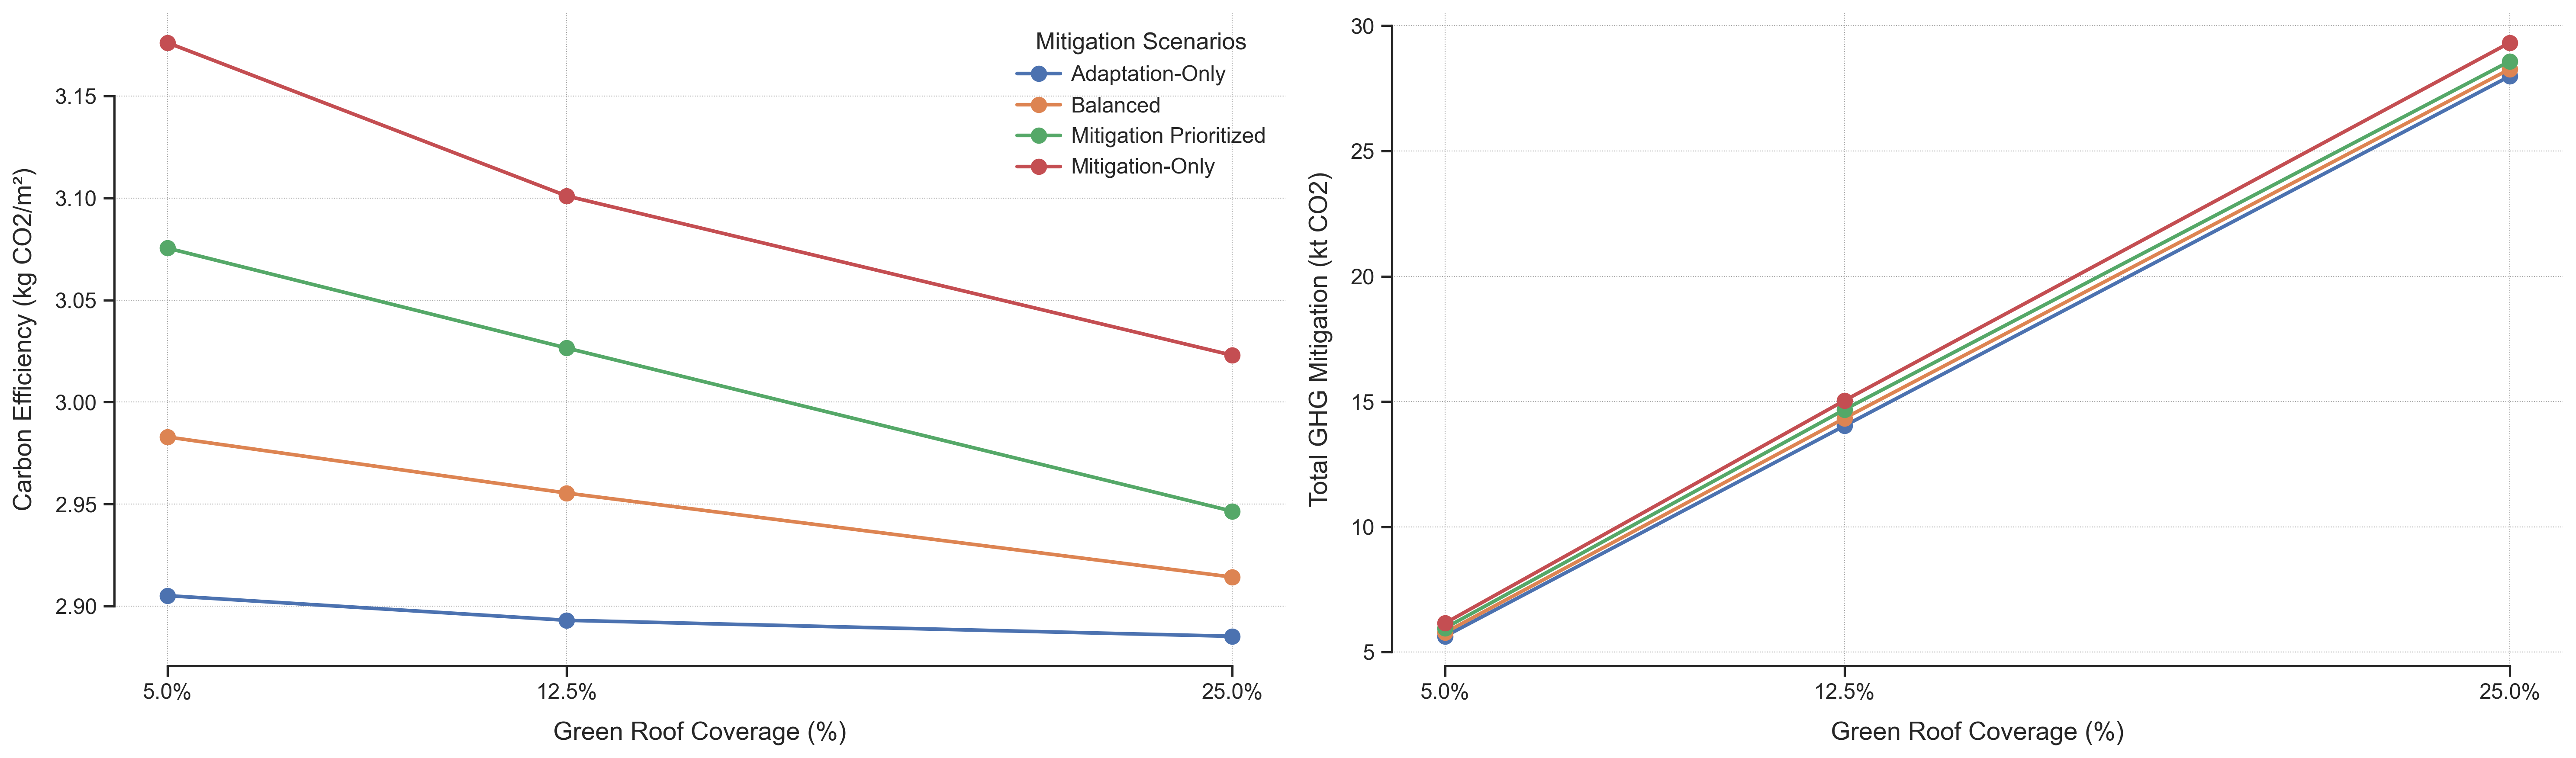

In [242]:
# Apply minimalistic and professional style
sns.set_theme(style="ticks", palette="dark")

# Set figure size and high DPI for academic quality
fig, axes = plt.subplots(1, 2, figsize=(20, 6), dpi=300)

# Define color palette (subtle, distinct colors for academic use)
colors = sns.color_palette("deep", len(carbon_scenarios))
# ---------- Plot Carbon Efficiency--------- 
for i, (scenario, color) in enumerate(zip(carbon_scenarios, colors)):
    axes[0].plot(coverage, co2_efficiency_per_m2[:, i], 
                 label=scenario, 
                 color=color, 
                 marker='o', 
                 markersize=8, 
                 linewidth=2)

# Customize plot title and labels
# axes[0].set_title("Carbon Efficiency Across Scenarios", fontsize=18, weight='bold', pad=15)
axes[0].set_xlabel("Green Roof Coverage (%)", fontsize=14, labelpad=10)
axes[0].set_ylabel("Carbon Efficiency (kg CO2/m²)", fontsize=14, labelpad=10)

# Customize tick labels
axes[0].set_xticks(coverage)
axes[0].set_xticklabels([f"{cov * 100:.1f}%" for cov in coverage], fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Add gridlines (subtle, dotted for sophistication)
axes[0].grid(visible=True, which='major', linestyle=':', linewidth=0.5, color='gray', alpha=0.7)

# Add a legend with clean formatting
axes[0].legend(title="Mitigation Scenarios", fontsize=12, title_fontsize=13, loc="upper right", 
               frameon=False, handletextpad=0.5, borderaxespad=0.5)

# Adjust spines for clean axes
sns.despine(ax=axes[0], trim=True)

# ------------ Plot Total CO2 Mitigated ----------
for i, (scenario, color) in enumerate(zip(carbon_scenarios, colors)):
    axes[1].plot(coverage, df_co2.iloc[:, i] , 
                 label=scenario, 
                 color=color, 
                 marker='o', 
                 markersize=8, 
                 linewidth=2)

# Customize plot title and labels
# axes[1].set_title("Carbon Accumulated Across Scenarios", fontsize=18, weight='bold', pad=15)
axes[1].set_xlabel("Green Roof Coverage (%)", fontsize=14, labelpad=10)
axes[1].set_ylabel("Total GHG Mitigation (kt CO2)", fontsize=14, labelpad=10)

# Customize tick labels
axes[1].set_xticks(coverage)
axes[1].set_xticklabels([f"{cov * 100:.1f}%" for cov in coverage], fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Add gridlines (subtle, dotted for sophistication)
axes[1].grid(visible=True, which='major', linestyle=':', linewidth=0.5, color='gray', alpha=0.7)

# Add a legend with clean formatting
# axes[1].legend(title="Mitigation Scenarios", fontsize=12, title_fontsize=13, loc="upper left", 
#                frameon=False, handletextpad=0.5, borderaxespad=0.5)

# Adjust spines for clean axes
sns.despine(ax=axes[1], trim=True)

# Tight layout for a polished figure
plt.tight_layout()

# Save the figure as a high-resolution image (e.g., for publication)
plt.savefig("carbon_efficiency_academic.png", bbox_inches="tight")

# Show the plot
plt.show()
